C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_3984\3388607903.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ITSM_data.csv")  # Update with your path if needed


=== Confusion Matrix ===
[[   0    1]
 [   0 9321]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00      9321

    accuracy                           1.00      9322
   macro avg       0.50      0.50      0.50      9322
weighted avg       1.00      1.00      1.00      9322



C:\Users\Ashutosh\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ashutosh\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ashutosh\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le


Total Anomalies Detected (Potential Misconfigurations): 2331
    CI_Name  CI_Cat  CI_Subcat  Status  Impact  Urgency  Priority  number_cnt  \
2       990       1         10       0       5        2       4.0    0.517551   
18     1050       1         10       0       2        2       3.0    0.860255   
19     2841       1         57       0       4        4       5.0    0.663615   
36     2713      11         57       0       4        4       5.0    0.433426   
39     2397       1         45       0       4        4       5.0    0.719923   

    Category  KB_number  Alert_Status  No_of_Reassignments  Open_Time  \
2          3        244             0                  3.0      23911   
18         1       1119             0                 17.0      32521   
19         1        292             0                  5.0       1109   
36         3        450             0                  3.0        556   
39         1        487             0                 25.0       3072   

    Handle_T

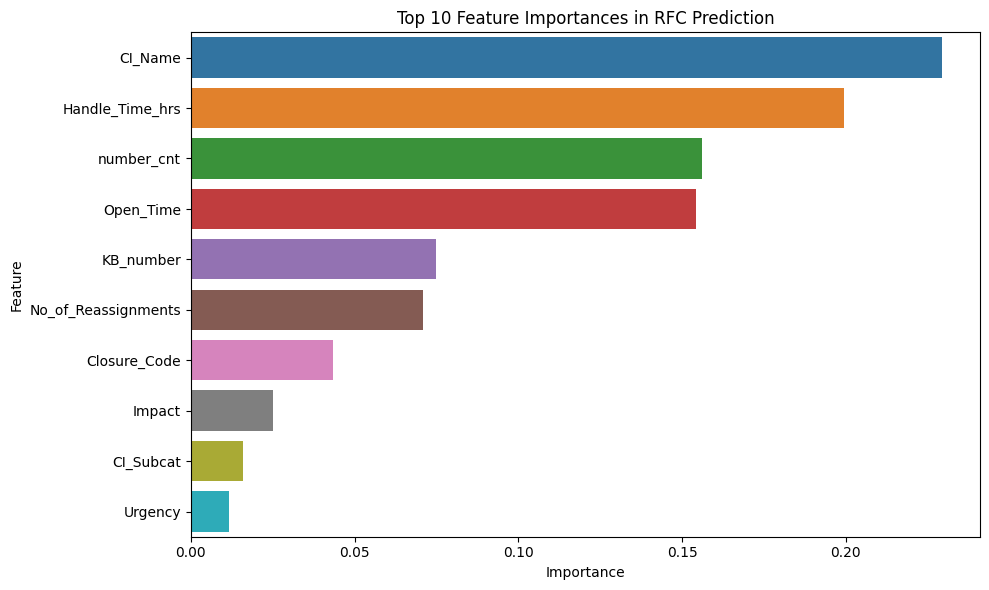

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- Load Data --------------------
df = pd.read_csv("ITSM_data.csv")  # Update with your path if needed

# -------------------- Target Variable --------------------
df['RFC_Success'] = df['Status'].apply(lambda x: 1 if str(x).strip().lower() == 'closed' else 0)

# -------------------- Drop Irrelevant/High-Null Columns --------------------
df.drop(columns=[
    'Incident_ID', 'Reopen_Time', 'Resolved_Time', 'Close_Time',
    'Related_Change', 'Related_Interaction', 'WBS'
], inplace=True)

# -------------------- Clean Handle_Time_hrs --------------------
df['Handle_Time_hrs'] = df['Handle_Time_hrs'].astype(str).str.replace(",", "", regex=False)
df['Handle_Time_hrs'] = pd.to_numeric(df['Handle_Time_hrs'], errors='coerce')

# -------------------- Fill Nulls --------------------
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# -------------------- Encode Categorical Columns --------------------
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str)  # Ensure all values are strings
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# -------------------- Split Features and Target --------------------
X = df.drop(columns=['RFC_Success', 'Status'])
y = df['RFC_Success']

# -------------------- Train-Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------- Train Classifier --------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# -------------------- Evaluation --------------------
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# -------------------- Anomaly Detection --------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(X_scaled)
df['Anomaly'] = [1 if x == -1 else 0 for x in anomaly_labels]

# Display anomalies
anomalies = df[df['Anomaly'] == 1]
print(f"\nTotal Anomalies Detected (Potential Misconfigurations): {len(anomalies)}")
print(anomalies.head())

# -------------------- Feature Importance --------------------
importances = rf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances in RFC Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
